In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Computes the convolution term Fvoigt(k) and saves it in an ASCII file. The inputs are a DLA and a QSO catalog (both as fits binary tables). The DLA table must contain the columns "MOCKID" matching qso "THING_ID", and "Z_DLA_RSD". The QSO table must contain the columns "THING_ID", and "Z"
"""
import sys
import argparse
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.special import wofz

import picca.constants as constants
from picca.utils import userprint

def voigt(x, sigma=1, gamma=1):
    return np.real(wofz((x + 1j*gamma)/(sigma*np.sqrt(2))))

def tau(lamb, z, N_hi):
    """ lamb = lambda in A and N_hi in log10(cm^-2) """

    lamb_rf = lamb/(1+z)
    e = 1.6021e-19 #C
    epsilon0 = 8.8541e-12 #C^2.s^2.kg^-1.m^-3
    f = 0.4164
    mp = 1.6726e-27 #kg
    me = 9.109e-31 #kg
    c = 2.9979e8 #m.s^-1
    k = 1.3806e-23 #m^2.kg.s^-2.K-1
    T = 1e4 #K
    gamma = 6.265e8 #s^-1
    lamb_alpha = constants.ABSORBER_IGM["LYA"] #A
    Deltat_lamb = lamb_alpha/c*np.sqrt(2*k*T/mp) #A

    a = gamma/(4*np.pi*Deltat_lamb)*lamb_alpha**2/c*1e-10
    u = (lamb_rf - lamb_alpha)/Deltat_lamb
    H = voigt(u, np.sqrt(1/2), a)

    absorb = np.sqrt(np.pi)*e**2*f*lamb_alpha**2*1e-10/(4*np.pi*epsilon0*me*c**2*Deltat_lamb)*H
    #10^N_hi en cm^-2 et absorb en m^2
    return 10**N_hi*1e4*absorb

def profile_voigt_lambda(x, z, N_hi):
    t = tau(x, z, N_hi).astype(float)
    return np.exp(-t)

def profile_lambda_to_r(lamb, profile_lambda, fidcosmo): #pour Lyman_alpha --> sinon mettre une autre raie
    z = lamb/constants.ABSORBER_IGM["LYA"] - 1
    r = fidcosmo.get_r_comov(z)
    rr = np.linspace(r[0], r[-1], r.size)
    profile_r = np.interp(rr,r,profile_lambda) #pour reavoir un echantillonage lineaire
    return rr, profile_r

def fft_profile(profile, dx): # non normalise
    n = profile.size
    tmp = (1-profile)
    ft_profile = dx*np.fft.fftshift(np.fft.fft(tmp))
    k = np.fft.fftshift(np.fft.fftfreq(n, dx))*(2*np.pi)
    return ft_profile, k

def lambda_to_r(lamb, profile_lambda, fidcosmo):
    """
    Converts a profile as a function of wavelength to a profile as a function of r in Mpc/h
    """

    z = lamb/constants.ABSORBER_IGM["LYA"] - 1
    r = fidcosmo.get_r_comov(z)
    rr = np.linspace(r[0], r[-1], r.size)
    profile_lambda = profile_lambda*fidcosmo.get_hubble(z)*constants.ABSORBER_IGM["LYA"]/3e5
    profile_r = np.interp(rr,r,profile_lambda)
    return rr, profile_r

def compute_dla_prob_per_nhi(wavelength,nhi,dla,qso,dnhi):
    """
    Computes the probability of finding a DLA with NHI= n+-dn and wavelength lambda +- dlambda
    - wavelength 1D array
    - nhi value of column density bin center log10(cm-2)
    - dla the DLA catalog (table)
    - qso the QSO catalog (table)
    - dnhi bin width log10(cm-2)
    """

    dla_lamb = (1 + dla['Z'])*constants.ABSORBER_IGM["LYA"]
    dla_nhi  = dla['NHI']
    qso_lamb = (1 + qso['Z'])*constants.ABSORBER_IGM["LYA"]
    dwave=np.gradient(wavelength)

    wbins = np.zeros(wavelength.size+1)
    wbins[:-1] = wavelength-dwave/2
    wbins[-1] = wavelength[-1]+dwave[-1]/2.

    ndla,_ = np.histogram(dla_lamb[np.abs(dla_nhi-nhi)<dnhi/2],bins=wbins)

    f = np.zeros(wavelength.size)
    for i,wave in enumerate(wavelength) :
        #n_dla = np.sum( (np.abs(dla_lamb-wave)<dwave[i]/2) & (np.abs(dla_nhi-nhi)<dnhi/2) )
        nqso = np.sum( qso_lamb > wave)
        if nqso>0 :
            f[i]  = ndla[i]/float(nqso)/dnhi/dwave[i]

    return f

def compute_dla_prob(wavelength, NHI, dla, qso, weight):

    """
    Computes the probability of finding a DLA
     - wavelength is 1 1D array
     - NHI is a 1D array of N(HI) in units of log10(cm^-2)
     - dla the DLA catalog (table)
     - qso the QSO catalog (table)
     - weights as a function of wavelength
    """
    dnhi=np.gradient(NHI)
    mean_density = np.zeros(NHI.size)
    for i,nhi in enumerate(NHI):
        userprint("compute prob(NHI={}) ({}/{})".format(nhi,(i+1),NHI.size))
        f = compute_dla_prob_per_nhi(wavelength,nhi=nhi,dla=dla,qso=qso,dnhi=dnhi[i])
        mean_density[i] = np.sum(f*weight)/np.sum(weight)
    return mean_density

In [2]:
from astropy.io import fits
hdul = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/desi-0.hcd-1000/dla_cat.fits')
print(hdul.info)
print(hdul[1].header)

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x155550031730>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x155550031640>]>
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                   32 / width of table in bytes                        NAXIS2  =               655575 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    4 / number of fields in each row                   TTYPE1  = 'NHI     '           / label for field   1                            TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            TTYPE2  = 'Z       '           / labe

# Correlation functions for Realistic, HCD -> 20, and HCD -> 17 mocks

compute prob(NHI=17.0) (1/51)
compute prob(NHI=17.1) (2/51)
compute prob(NHI=17.2) (3/51)
compute prob(NHI=17.3) (4/51)
compute prob(NHI=17.4) (5/51)
compute prob(NHI=17.5) (6/51)
compute prob(NHI=17.6) (7/51)
compute prob(NHI=17.7) (8/51)
compute prob(NHI=17.8) (9/51)
compute prob(NHI=17.9) (10/51)
compute prob(NHI=18.0) (11/51)
compute prob(NHI=18.1) (12/51)
compute prob(NHI=18.2) (13/51)
compute prob(NHI=18.3) (14/51)
compute prob(NHI=18.4) (15/51)
compute prob(NHI=18.5) (16/51)
compute prob(NHI=18.6) (17/51)
compute prob(NHI=18.7) (18/51)
compute prob(NHI=18.8) (19/51)
compute prob(NHI=18.9) (20/51)
compute prob(NHI=19.0) (21/51)
compute prob(NHI=19.1) (22/51)
compute prob(NHI=19.2) (23/51)
compute prob(NHI=19.3) (24/51)
compute prob(NHI=19.4) (25/51)
compute prob(NHI=19.5) (26/51)
compute prob(NHI=19.6) (27/51)
compute prob(NHI=19.7) (28/51)
compute prob(NHI=19.8) (29/51)
compute prob(NHI=19.9) (30/51)
compute prob(NHI=20.0) (31/51)
compute prob(NHI=20.1) (32/51)
compute prob(NHI=

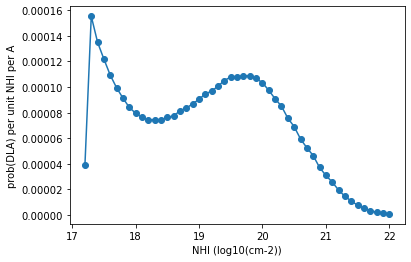

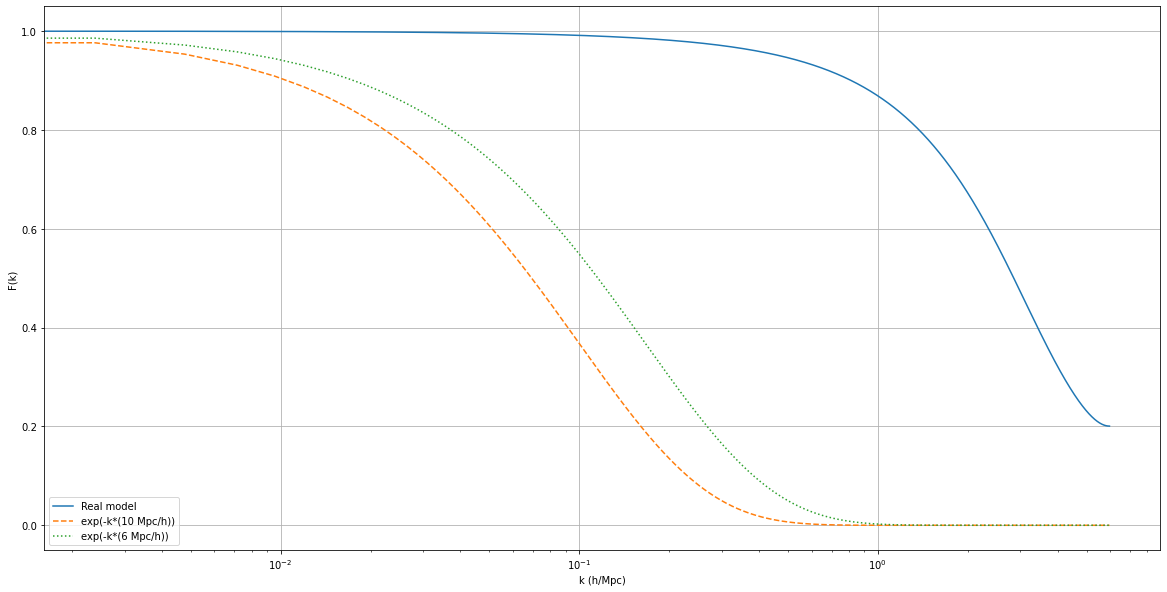

In [3]:
#     parser = argparse.ArgumentParser(
#         formatter_class=argparse.ArgumentDefaultsHelpFormatter,
#         description=('Computes the convolution term Fvoigt(k) and saves it in '
#                      'an ASCII file. The inputs are a DLA and a QSO catalog '
#                      '(both as fits binary tables). The DLA table must contain '
#                      'the columns "MOCKID" matching qso "THING_ID", and '
#                      '"Z_DLA_RSD". The QSO table must contain the columns '
#                      '"THING_ID", and "Z"'))

#     parser.add_argument(
#         '--dla-catalog',
#         type=str,
#         default=None,
#         required=True,
#         help=('DLA catalog fits file , like '
#               '/project/projectdirs/desi/mocks/lya_forest/develop/saclay/v4.4/v4.4.3/master_DLA.fits'))

#     parser.add_argument(
#         '--drq-catalog',
#         type=str,
#         default=None,
#         required=True,
#         help=('DRQ catalog fits file, like '
#               '/project/projectdirs/desi/mocks/lya_forest/develop/saclay/v4.4/v4.4.3/eboss-0.2/zcat_desi_drq.fits'))

#     parser.add_argument(
#         '--weight-vs-wavelength',
#         type=str,
#         default=None,
#         required=False,
#         help=('sum of delta weight as a function of wavelength (two columns '
#               'ASCII file)'))

#     parser.add_argument(
#         '-o', '--output',
#         type=str,
#         default=None,
#         required=True,
#         help='FVoigt as a function of k in h/Mpc (two columns ASCII file)')

#     parser.add_argument('-d','--debug', action='store_true', default=True)

#     parser.add_argument('-p','--plot', action='store_true',
#                         help="show some plots")


#     args = parser.parse_args(cmdargs)

debug = False

if debug:
    userprint("read DLA catalog")
dla = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/desi-0.hcd-1000/dla_cat.fits')[1].data

if debug:
    userprint("read DRQ catalog")
qso = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/zcat_drq.fits')[1].data

if debug:
    userprint("only keep DLAs in DRQ quasars LOS")
dla = dla[:][np.in1d(dla['TARGETID'], qso['THING_ID'])]

coarse_wavelength = np.arange(3000, 8000, 100)

weight_vs_wavelength = None

if weight_vs_wavelength is None:
    filename = "/global/common/software/desi/users/jguy/igmhub/code_stage_lbl/build_Fvoigt/data/weight_lambda.txt"
    userprint("WARNING: Hardcoded weight vs wavelength file {}".format(filename))
    weight_vs_wavelength = filename

if weight_vs_wavelength is not None:
    if debug:
        userprint("read weights vs wave")
    tmp = np.loadtxt(weight_vs_wavelength)
    weight = np.interp(coarse_wavelength, tmp[:, 0], tmp[:, 1])
else :
    weight = np.ones(coarse_wavelength.shape)

zdla = np.mean(dla['Z'])
NHI = np.linspace(17, 22, 51)

# probability of finding a DLA at NHI in a QSO LOS (per A and per unit NHI)
# averaged over wavelength, using the provided wavelength weight
prob = compute_dla_prob(coarse_wavelength, NHI, dla=dla, qso=qso, weight=weight)

ii=(prob > 0)
prob=prob[ii]
NHI=NHI[ii]

plot = True

if plot :
    plt.figure("prob")
    plt.plot(NHI,prob,"o-")
    plt.xlabel("NHI (log10(cm-2))")
    plt.ylabel("prob(DLA) per unit NHI per A")

# now use a finer wavelength grid
wavelength = np.arange(3000, 8000, 1.)
# conversion A -> Mpc/h
fidcosmo = constants.Cosmo(Om=0.3)
r_wave   = fidcosmo.get_r_comov(wavelength/constants.ABSORBER_IGM["LYA"] - 1)
# linear grid of Mpc/h (need to convert to linear grid for the FFT)
r_lin    = np.linspace(r_wave[0],r_wave[-1],r_wave.size)

for i in range(NHI.size):

    if debug : userprint("compute dF/dNHI for NHI={} ({}/{})".format(NHI[i],(i+1),NHI.size))
    profile   = profile_voigt_lambda(wavelength, zdla, 17)#NHI[i])
    profile_r = np.interp(r_lin,r_wave,profile) # interpolation to linear r grid
    # r is in Mpc h^-1 --> k in h*Mpc^-1
    ft_profile, k = fft_profile(profile_r, np.abs(r_lin[1]-r_lin[0]))
    ft_profile = np.abs(ft_profile)
    if i == 0:
        df = np.array([ft_profile*prob[i]])
    else:
        df = np.concatenate((df, np.array([ft_profile*prob[i]])))

Fvoigtreal = df[0]
Fvoigtreal = Fvoigtreal/Fvoigtreal[k.size//2]

ii=(k>=0)
k=k[ii]
Fvoigtreal=Fvoigtreal[ii]

output = "output_Fvoigtreal.txt"

if debug : userprint("save in {}".format(args.output))
np.savetxt(output, np.array([k,Fvoigtreal]).T)

if plot :
    plt.figure("fk", figsize=(20,10))
    plt.plot(k,Fvoigtreal,label="Real model")
    plt.plot(k,np.exp(-k*10),"--",label="exp(-k*(10 Mpc/h))")
    plt.plot(k,np.exp(-k*6),":",label="exp(-k*(6 Mpc/h))")
    plt.xscale("log")
    plt.xlabel("k (h/Mpc)")
    plt.ylabel("F(k)")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

compute prob(NHI=17.0) (1/51)
compute prob(NHI=17.1) (2/51)
compute prob(NHI=17.2) (3/51)
compute prob(NHI=17.3) (4/51)
compute prob(NHI=17.4) (5/51)
compute prob(NHI=17.5) (6/51)
compute prob(NHI=17.6) (7/51)
compute prob(NHI=17.7) (8/51)
compute prob(NHI=17.8) (9/51)
compute prob(NHI=17.9) (10/51)
compute prob(NHI=18.0) (11/51)
compute prob(NHI=18.1) (12/51)
compute prob(NHI=18.2) (13/51)
compute prob(NHI=18.3) (14/51)
compute prob(NHI=18.4) (15/51)
compute prob(NHI=18.5) (16/51)
compute prob(NHI=18.6) (17/51)
compute prob(NHI=18.7) (18/51)
compute prob(NHI=18.8) (19/51)
compute prob(NHI=18.9) (20/51)
compute prob(NHI=19.0) (21/51)
compute prob(NHI=19.1) (22/51)
compute prob(NHI=19.2) (23/51)
compute prob(NHI=19.3) (24/51)
compute prob(NHI=19.4) (25/51)
compute prob(NHI=19.5) (26/51)
compute prob(NHI=19.6) (27/51)
compute prob(NHI=19.7) (28/51)
compute prob(NHI=19.8) (29/51)
compute prob(NHI=19.9) (30/51)
compute prob(NHI=20.0) (31/51)
compute prob(NHI=20.1) (32/51)
compute prob(NHI=

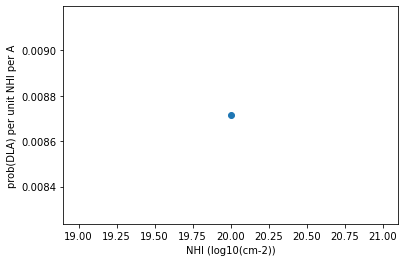

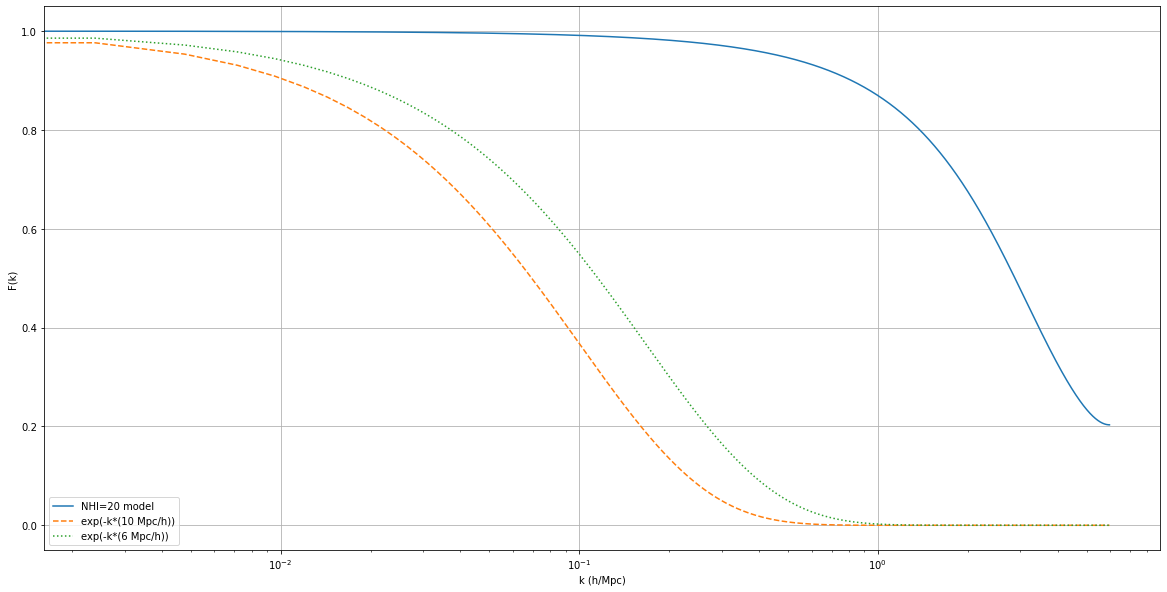

In [4]:
debug = False

if debug:
    userprint("read DLA catalog")
dla = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/desi-h20.15-1000/dla_cat.fits')[1].data

if debug:
    userprint("read DRQ catalog")
qso = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/desi-h20.15-1000/zcat_drq.fits')[1].data

if debug:
    userprint("only keep DLAs in DRQ quasars LOS")
dla = dla[:][np.in1d(dla['TARGETID'], qso['THING_ID'])]

coarse_wavelength = np.arange(3000, 8000, 100)

weight_vs_wavelength = None

if weight_vs_wavelength is None:
    filename = "/global/common/software/desi/users/jguy/igmhub/code_stage_lbl/build_Fvoigt/data/weight_lambda.txt"
    userprint("WARNING: Hardcoded weight vs wavelength file {}".format(filename))
    weight_vs_wavelength = filename

if weight_vs_wavelength is not None:
    if debug:
        userprint("read weights vs wave")
    tmp = np.loadtxt(weight_vs_wavelength)
    weight = np.interp(coarse_wavelength, tmp[:, 0], tmp[:, 1])
else :
    weight = np.ones(coarse_wavelength.shape)

zdla = np.mean(dla['Z'])
NHI = np.linspace(17, 22, 51)

# probability of finding a DLA at NHI in a QSO LOS (per A and per unit NHI)
# averaged over wavelength, using the provided wavelength weight
prob = compute_dla_prob(coarse_wavelength, NHI, dla=dla, qso=qso, weight=weight)

ii=(prob > 0)
prob=prob[ii]
NHI=NHI[ii]

plot = True

if plot :
    plt.figure("prob")
    plt.plot(NHI,prob,"o-")
    plt.xlabel("NHI (log10(cm-2))")
    plt.ylabel("prob(DLA) per unit NHI per A")

# now use a finer wavelength grid
wavelength = np.arange(3000, 8000, 1.)
# conversion A -> Mpc/h
fidcosmo = constants.Cosmo(Om=0.3)
r_wave   = fidcosmo.get_r_comov(wavelength/constants.ABSORBER_IGM["LYA"] - 1)
# linear grid of Mpc/h (need to convert to linear grid for the FFT)
r_lin    = np.linspace(r_wave[0],r_wave[-1],r_wave.size)

for i in range(NHI.size):

    if debug : userprint("compute dF/dNHI for NHI={} ({}/{})".format(NHI[i],(i+1),NHI.size))
    profile   = profile_voigt_lambda(wavelength, zdla, 17)#NHI[i])
    profile_r = np.interp(r_lin,r_wave,profile) # interpolation to linear r grid
    # r is in Mpc h^-1 --> k in h*Mpc^-1
    ft_profile, k = fft_profile(profile_r, np.abs(r_lin[1]-r_lin[0]))
    ft_profile = np.abs(ft_profile)
    if i == 0:
        df = np.array([ft_profile*prob[i]])
    else:
        df = np.concatenate((df, np.array([ft_profile*prob[i]])))

Fvoigt20 = df[0]
Fvoigt20 = Fvoigt20/Fvoigt20[k.size//2]

ii=(k>=0)
k=k[ii]
Fvoigt20=Fvoigt20[ii]

output = "output_Fvoigt20.txt"

if debug : userprint("save in {}".format(args.output))
np.savetxt(output, np.array([k,Fvoigt20]).T)

if plot :
    plt.figure("fk", figsize=(20,10))
    plt.plot(k,Fvoigt20,label="NHI=20 model")
    plt.plot(k,np.exp(-k*10),"--",label="exp(-k*(10 Mpc/h))")
    plt.plot(k,np.exp(-k*6),":",label="exp(-k*(6 Mpc/h))")
    plt.xscale("log")
    plt.xlabel("k (h/Mpc)")
    plt.ylabel("F(k)")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

compute prob(NHI=17.0) (1/51)
compute prob(NHI=17.1) (2/51)
compute prob(NHI=17.2) (3/51)
compute prob(NHI=17.3) (4/51)
compute prob(NHI=17.4) (5/51)
compute prob(NHI=17.5) (6/51)
compute prob(NHI=17.6) (7/51)
compute prob(NHI=17.7) (8/51)
compute prob(NHI=17.8) (9/51)
compute prob(NHI=17.9) (10/51)
compute prob(NHI=18.0) (11/51)
compute prob(NHI=18.1) (12/51)
compute prob(NHI=18.2) (13/51)
compute prob(NHI=18.3) (14/51)
compute prob(NHI=18.4) (15/51)
compute prob(NHI=18.5) (16/51)
compute prob(NHI=18.6) (17/51)
compute prob(NHI=18.7) (18/51)
compute prob(NHI=18.8) (19/51)
compute prob(NHI=18.9) (20/51)
compute prob(NHI=19.0) (21/51)
compute prob(NHI=19.1) (22/51)
compute prob(NHI=19.2) (23/51)
compute prob(NHI=19.3) (24/51)
compute prob(NHI=19.4) (25/51)
compute prob(NHI=19.5) (26/51)
compute prob(NHI=19.6) (27/51)
compute prob(NHI=19.7) (28/51)
compute prob(NHI=19.8) (29/51)
compute prob(NHI=19.9) (30/51)
compute prob(NHI=20.0) (31/51)
compute prob(NHI=20.1) (32/51)
compute prob(NHI=

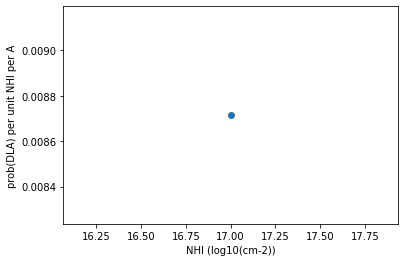

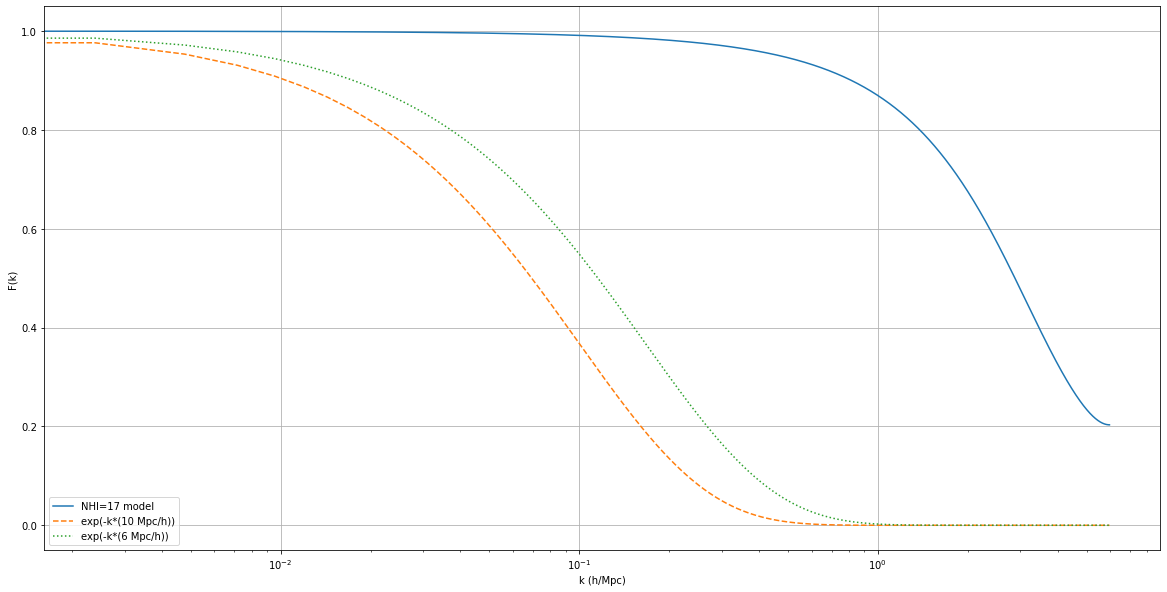

In [5]:
debug = False

if debug:
    userprint("read DLA catalog")
dla = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/desi-h17.15-1000/dla_cat.fits')[1].data

if debug:
    userprint("read DRQ catalog")
qso = fits.open('/global/cfs/projectdirs/desi/users/acuceu/run/qq/desi-h17.15-1000/zcat_drq.fits')[1].data

if debug:
    userprint("only keep DLAs in DRQ quasars LOS")
dla = dla[:][np.in1d(dla['TARGETID'], qso['THING_ID'])]

coarse_wavelength = np.arange(3000, 8000, 100)

weight_vs_wavelength = None

if weight_vs_wavelength is None:
    filename = "/global/common/software/desi/users/jguy/igmhub/code_stage_lbl/build_Fvoigt/data/weight_lambda.txt"
    userprint("WARNING: Hardcoded weight vs wavelength file {}".format(filename))
    weight_vs_wavelength = filename

if weight_vs_wavelength is not None:
    if debug:
        userprint("read weights vs wave")
    tmp = np.loadtxt(weight_vs_wavelength)
    weight = np.interp(coarse_wavelength, tmp[:, 0], tmp[:, 1])
else :
    weight = np.ones(coarse_wavelength.shape)

zdla = np.mean(dla['Z'])
NHI = np.linspace(17, 22, 51)

# probability of finding a DLA at NHI in a QSO LOS (per A and per unit NHI)
# averaged over wavelength, using the provided wavelength weight
prob = compute_dla_prob(coarse_wavelength, NHI, dla=dla, qso=qso, weight=weight)

ii=(prob > 0)
prob=prob[ii]
NHI=NHI[ii]

plot = True

if plot :
    plt.figure("prob")
    plt.plot(NHI,prob,"o-")
    plt.xlabel("NHI (log10(cm-2))")
    plt.ylabel("prob(DLA) per unit NHI per A")

# now use a finer wavelength grid
wavelength = np.arange(3000, 8000, 1.)
# conversion A -> Mpc/h
fidcosmo = constants.Cosmo(Om=0.3)
r_wave   = fidcosmo.get_r_comov(wavelength/constants.ABSORBER_IGM["LYA"] - 1)
# linear grid of Mpc/h (need to convert to linear grid for the FFT)
r_lin    = np.linspace(r_wave[0],r_wave[-1],r_wave.size)

for i in range(NHI.size):

    if debug : userprint("compute dF/dNHI for NHI={} ({}/{})".format(NHI[i],(i+1),NHI.size))
    profile   = profile_voigt_lambda(wavelength, zdla, 17)#NHI[i])
    profile_r = np.interp(r_lin,r_wave,profile) # interpolation to linear r grid
    # r is in Mpc h^-1 --> k in h*Mpc^-1
    ft_profile, k = fft_profile(profile_r, np.abs(r_lin[1]-r_lin[0]))
    ft_profile = np.abs(ft_profile)
    if i == 0:
        df = np.array([ft_profile*prob[i]])
    else:
        df = np.concatenate((df, np.array([ft_profile*prob[i]])))

Fvoigt17 = df[0]
Fvoigt17 = Fvoigt17/Fvoigt17[k.size//2]

ii=(k>=0)
k=k[ii]
Fvoigt17=Fvoigt17[ii]

output = "output_Fvoigt17.txt"

if debug : userprint("save in {}".format(args.output))
np.savetxt(output, np.array([k,Fvoigt17]).T)

if plot :
    plt.figure("fk", figsize=(20,10))
    plt.plot(k,Fvoigt17,label="NHI=17 model")
    plt.plot(k,np.exp(-k*10),"--",label="exp(-k*(10 Mpc/h))")
    plt.plot(k,np.exp(-k*6),":",label="exp(-k*(6 Mpc/h))")
    plt.xscale("log")
    plt.xlabel("k (h/Mpc)")
    plt.ylabel("F(k)")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()